unzip the data -> Define image directory -> create empty list for image and label -> define parasitize image directory -> loop through the directory and read the image -> resize the image -> conver back to np array and add to the dataset -> add label to label list -> repeat the same for the uninfeected data.

In [47]:
import warnings
warnings.filterwarnings('ignore')

In [48]:
# unzip

!unzip /content/malaria.zip

Archive:  /content/malaria.zip
replace cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [49]:
# import the libraries

import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [50]:
# count the number of images

ROOT_DIR = "/content/cell_images"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR,dir)))

number_of_images.items()

dict_items([('Parasitized', 13780), ('Uninfected', 13780)])

In [52]:
dataset = []
label = []

parasitized_image_path = '/content/cell_images/Parasitized'

for image_name in os.listdir(parasitized_image_path):
  if image_name.split('.')[1] == 'png':
    image_arr = cv2.imread(os.path.join(parasitized_image_path,image_name))
    image = Image.fromarray(image_arr, 'RGB')
    image_resize = image.resize((64,64))
    image_fin = np.asarray(image_resize)
    dataset.append(image_fin)
    label.append(0)

In [53]:
uninfected_image_path = '/content/cell_images/Uninfected'


for image_name in os.listdir(uninfected_image_path):
  if image_name.split('.')[1] == 'png':
    image_arr = cv2.imread(os.path.join(uninfected_image_path,image_name))
    image = Image.fromarray(image_arr, 'RGB')
    image_resize = image.resize((64,64))
    image_fin = np.asarray(image_resize)
    dataset.append(image_fin)
    label.append(1)

In [54]:
len(label)

27558

In [55]:
y = np.asarray(label)

import the dependencies

In [56]:
import keras
from keras import layers, Model

train test split

In [57]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [58]:
X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(y), test_size= 0.2, random_state = 7, shuffle = True)

Input layer -> (conv -> maxpool -> norm -> dropout)*2 -> flatten -> (dense -> norm -> dorpout)*2 -> output layer (sigmoid) 

In [72]:
Input_Shape = (64,64,3)
inp_layer = layers.Input(shape= Input_Shape)

con_1 = layers.Conv2D(32,kernel_size =(3,3),activation= 'relu')(inp_layer)
pool_1 = layers.MaxPool2D(pool_size = (2,2))(con_1)
norm_1 = layers.BatchNormalization(axis = -1)(pool_1)
drop_1 = layers.Dropout(rate = 0.4)(norm_1)

con_2 = layers.Conv2D(64,kernel_size =(3,3),activation= 'relu')(drop_1)
pool_2 = layers.MaxPool2D(pool_size = (2,2))(con_2)
norm_2 = layers.BatchNormalization(axis = -1)(pool_2)
drop_2 = layers.Dropout(rate = 0.4)(norm_2)

flat = layers.Flatten()(drop_2)

dense_1 = layers.Dense(512,activation = 'relu')(flat)
norm_3 = layers.BatchNormalization(axis = -1)(dense_1)
drop_3 = layers.Dropout(rate = 0.5)(norm_3 )

dense_2 = layers.Dense(256,activation = 'relu')(drop_3)
norm_4 = layers.BatchNormalization(axis = -1)(dense_2)
drop_4 = layers.Dropout(rate = 0.4)(norm_4)

output_layer = layers.Dense(units = 2, activation='sigmoid')(drop_4)

model = Model(inputs = inp_layer, outputs = output_layer)

In [73]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_20 (Bat  (None, 31, 31, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 29, 29, 64)        1849

Compile the model: adam optimizer ; loos: catagorical_crossentropy; metrics: accuracy

In [74]:
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['accuracy'])

Train the model

In [62]:
# early stop and checkpoints

from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor='val_accuracy', min_delta= 0.5, patience = 10, verbose = 1, mode = 'auto')
mcp = ModelCheckpoint(monitor='val_accuracy', filepath= './bestmodel.h5', verbose = 1, save_best_only = True, mode = 'auto')

cb = [es, mcp]

In [75]:
# train the model

history = model.fit(np.array(X_train), y_train, batch_size = 64, verbose = 1, epochs = 20, validation_split = 0.1, shuffle = False)

Epoch 1/20
311/311 [==============================] - 8s 14ms/step - loss: 0.6401 - accuracy: 0.7130 - val_loss: 2.4616 - val_accuracy: 0.5751
Epoch 2/20
311/311 [==============================] - 4s 13ms/step - loss: 0.2786 - accuracy: 0.8957 - val_loss: 0.3046 - val_accuracy: 0.8912
Epoch 3/20
311/311 [==============================] - 4s 14ms/step - loss: 0.2265 - accuracy: 0.9175 - val_loss: 0.3193 - val_accuracy: 0.8984
Epoch 4/20
311/311 [==============================] - 4s 13ms/step - loss: 0.2085 - accuracy: 0.9255 - val_loss: 0.1948 - val_accuracy: 0.9247
Epoch 5/20
311/311 [==============================] - 4s 14ms/step - loss: 0.1921 - accuracy: 0.9317 - val_loss: 0.3201 - val_accuracy: 0.8653
Epoch 6/20
311/311 [==============================] - 4s 14ms/step - loss: 0.1831 - accuracy: 0.9350 - val_loss: 0.2535 - val_accuracy: 0.8961
Epoch 7/20
311/311 [==============================] - 4s 13ms/step - loss: 0.1744 - accuracy: 0.9394 - val_loss: 0.3563 - val_accuracy: 0.8816

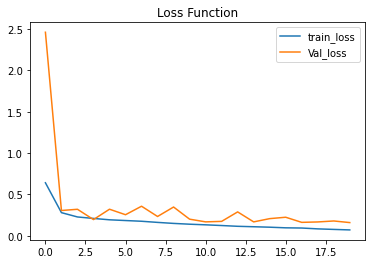

In [76]:
# loss function

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss Function')
plt.legend(['train_loss', 'Val_loss'])
plt.show()

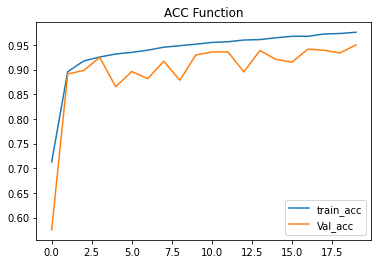

In [77]:
# accuarcy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('ACC Function')
plt.legend(['train_acc', 'Val_acc'])
plt.show()

In [ ]:
# save best model

#from keras.models import load_model

#best_model = load_model("/content/bestmodel.h5")

In [78]:
loss, acc = model.evaluate(np.array(X_test), np.array(y_test)) 
print('The accuracy score is', acc*100)

173/173 [==============================] - 1s 4ms/step - loss: 0.1476 - accuracy: 0.9532
The accuracy score is 95.31930088996887
